In [1]:
import xgboost
import numpy as np
import shap

/home/jarek/projects/shap/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# simulate some binary data and a linear outcome with an interaction term
# note we make the features in X perfectly independent of each other to make
# it easy to solve for the exact SHAP values
N = 2000
X = np.zeros((N,5))
X[:1000,0] = 1
X[:500,1] = 1
X[1000:1500,1] = 1
X[:250,2] = 1
X[500:750,2] = 1
X[1000:1250,2] = 1
X[1500:1750,2] = 1
X[:,0:3] -= 0.5
y = 2*X[:,0] - 3*X[:,1]

In [3]:
# ensure the variables are independent
np.cov(X.T)

# array([[0.25012506, 0.        , 0.        , 0.        , 0.        ],
#        [0.        , 0.25012506, 0.        , 0.        , 0.        ],
#        [0.        , 0.        , 0.25012506, 0.        , 0.        ],
#        [0.        , 0.        , 0.        , 0.        , 0.        ],
#        [0.        , 0.        , 0.        , 0.        , 0.        ]])


array([[0.25012506, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.25012506, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.25012506, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [4]:
# and mean centered
X.mean(0)

# array([0., 0., 0., 0., 0.])

array([0., 0., 0., 0., 0.])

In [5]:
# train a model with single tree
Xd = xgboost.DMatrix(X, label=y)
model = xgboost.train({
    'eta':1, 'max_depth':3, 'base_score': 0, "lambda": 0
}, Xd, 1)
print("Model error =", np.linalg.norm(y-model.predict(Xd)))
print(model.get_dump(with_stats=True)[0])

# Model error = 0.0
# 0:[f1<0] yes=1,no=2,missing=1,gain=4500,cover=2000
#         1:[f0<0] yes=3,no=4,missing=3,gain=1000,cover=1000
#                 3:leaf=0.5,cover=500
#                 4:leaf=2.5,cover=500
#         2:[f0<0] yes=5,no=6,missing=5,gain=1000,cover=1000
#                 5:leaf=-2.5,cover=500
#                 6:leaf=-0.5,cover=500

Model error = 0.0
0:[f1<0] yes=1,no=2,missing=1,gain=4500,cover=2000
	1:[f0<0] yes=3,no=4,missing=3,gain=1000,cover=1000
		3:leaf=0.5,cover=500
		4:leaf=2.5,cover=500
	2:[f0<0] yes=5,no=6,missing=5,gain=1000,cover=1000
		5:leaf=-2.5,cover=500
		6:leaf=-0.5,cover=500



In [6]:
# make sure the SHAP values add up to marginal predictions
pred = model.predict(Xd, output_margin=True)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xd)
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

# 0.0

0.0

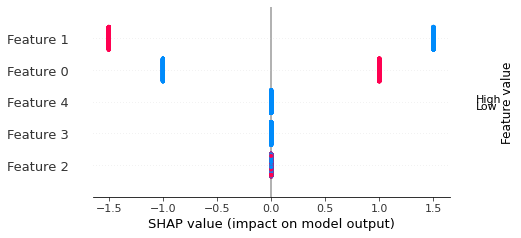

In [7]:
shap.summary_plot(shap_values, X)

# now we make a banzhaf value model

In [8]:
# from shap.explainers import pytree

# banz_explainer = pytree.BanzTreeExplainer(model)
# shap_values = banz_explainer.shap_values(Xd)
# np.abs(shap_values.sum(1) + banz_explainer.expected_value - pred).max()


In [9]:
# shap.summary_plot(shap_values, X)
shap_values

array([[ 1. , -1.5,  0. ,  0. ,  0. ],
       [ 1. , -1.5,  0. ,  0. ,  0. ],
       [ 1. , -1.5,  0. ,  0. ,  0. ],
       ...,
       [-1. ,  1.5,  0. ,  0. ,  0. ],
       [-1. ,  1.5,  0. ,  0. ,  0. ],
       [-1. ,  1.5,  0. ,  0. ,  0. ]], dtype=float32)

In [10]:
# from: 
# https://towardsdatascience.com/introduction-to-shap-values-and-their-application-in-machine-learning-8003718e6827

In [11]:
import pandas as pd

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.datasets import *
from sklearn.tree import *

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datase

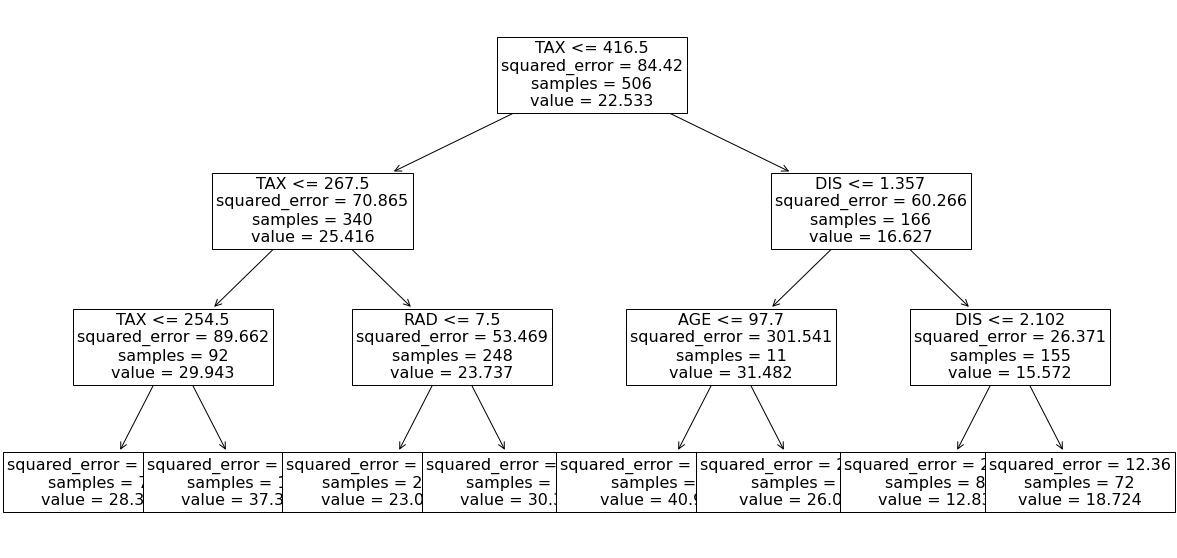

In [12]:
# Listing 20

from sklearn import datasets

d = datasets.load_boston()
df = pd.DataFrame(d['data'], columns=d['feature_names'])
y = pd.Series(d['target'])
X = df[['AGE', 'RAD', 'TAX', 'DIS']]
 
tree_model = DecisionTreeRegressor(max_depth=3)
tree_model.fit(X, y)
fig = plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X.columns, fontsize =16)
plt.show()

In [13]:
# Listing 21
def expvalue(clf, x, S):
    def g(node, w):
        left_child = clf.tree_.children_left[node]
        right_child = clf.tree_.children_right[node]
        if left_child == right_child:  # node is a leaf 
            return w*clf.tree_.value[node].squeeze()
        else: # internal node
            feature = x.index[clf.tree_.feature[node]]
            if feature in S:
                if x.loc[feature] <= clf.tree_.threshold[node]:
                    return g(left_child, w) 
                else:
                    return g(right_child, w) 
            else:    
                w_left = clf.tree_.n_node_samples[left_child] / clf.tree_.n_node_samples[node]
                w_right = clf.tree_.n_node_samples[right_child] / clf.tree_.n_node_samples[node]
                return g(left_child, w * w_left) + g(right_child, w * w_right)
    return g(0,1)

In [14]:
# Listing 22

from itertools import combinations
import scipy

def coalitions(x, col):
    remaining_features = [feature for feature in x.index if feature != col]
    for feature in range(len(remaining_features) + 1):
        for coalition in combinations(remaining_features, feature):
            yield list(coalition)
            
def coalition_contribution1(model, x, col, coalition):
    marginal_gain = expvalue(model, x, coalition + [col]) - expvalue(model, x, coalition)
    num_coalitions = 1 / (scipy.special.comb(len(x) - 1, len(coalition)) * len(x))
    return num_coalitions * marginal_gain  
            
def calculate_exact_tree_shap_values(model, X_sample):
    if isinstance(X_sample, pd.Series):
        X_sample = pd.DataFrame(X_sample).T
    shap_values_list = []
    for i in range(X_sample.shape[0]):
        x = X_sample.iloc[i]
        shap_values = []
        for col in X_sample.columns:
            shap_value =  np.sum([coalition_contribution1(model, x, col, coalition) for coalition in coalitions(x, col)])
            shap_values.append(shap_value)
        shap_values_list.append(shap_values)
    return model.tree_.value[0].squeeze().item(), shap_values_list

In [15]:
# Listing 23
calculate_exact_tree_shap_values(tree_model, X.iloc[470])

(22.532806324110698,
 [[0.17363555010556136,
   1.6225955204216118,
   -6.753886031609971,
   1.1484597480832435]])

In [16]:
# Listing 24
def tree_shap(tree, X_explain):
    if isinstance(X_explain, pd.Series):
        X_explain = X_explain.values
    elif isinstance(X_explain, pd.DataFrame):
        X_explain = X_explain.values
    tree = tree.tree_

    if len(X_explain.shape) == 1:
        phi = np.zeros(X_explain.shape[0])
        calculate_tree_shap(tree, X_explain, phi)
    elif len(X_explain.shape) == 2:
        phi = np.zeros((X_explain.shape[0], X_explain.shape[1]))
        for i in range(X_explain.shape[0]):
            calculate_tree_shap(tree, X_explain[i,:], phi[i,:])
    return tree.value.squeeze()[0].item(), phi
  
def extend(m, pz, po, pi): 
    l = len(m)
    m = m.copy()
    m.loc[l] = [pi, pz, po, 1 if l==0 else 0]  

    for i in range(l - 1, -1, -1):
        m.iloc[i+1]['w'] += po * m.iloc[i]['w'] * (i + 1) / (l + 1)
        m.iloc[i]['w'] = pz * m.iloc[i]['w'] * (l - i) / (l + 1)
    return m


def unwind(m, i): 
    m = m.copy()
    l = len(m) - 1
    n = m.iloc[l]['w'] 
    for j in range(l - 1, -1, -1):
        if m.iloc[i]['o'] != 0:
            temp = m.iloc[j]['w']
            m.iloc[j]['w'] = n * (l + 1) / ((j + 1) * m.iloc[i]['o'])
            n = temp - m.loc[j]['w'] * m.loc[i]['z'] * (l - j) / (l + 1)
        else:
            m.iloc[j]['w'] = (m.iloc[j]['w'] * (l + 1)) / (m.iloc[i]['z'] * (l - j))

    for j in range(i, l):
        m.iloc[j]['d'] = m.loc[j+1]['d']
        m.iloc[j]['z'] = m.loc[j+1]['z']
        m.iloc[j]['o'] = m.loc[j+1]['o']
    return m.iloc[:l] 

def calculate_tree_shap(tree, x, phi):
    def tree_shap_recursive(j, m, pz, po, pi):   
        # extend the unique path
        m = extend(m, pz, po, pi)
        dj = features[j]

        # leaf node
        if children_right[j] == -1:
            for i in range(1, len(m)):
                w = unwind(m, i).w.sum()
                phi[int(m.iloc[i]["d"])] += w * (m.iloc[i]["o"] - m.iloc[i]["z"]) * values[j] 

        # internal node
        else:
            h = 0
            cleft = children_left[j]
            cright = children_right[j]

            h = cleft if x[dj] < thresholds[j] else cright
            c = cright if h == cleft else cleft
            rj = node_sample_weight[j]
            rh = node_sample_weight[h] 
            rc = node_sample_weight[c] 
            iz = 1
            io = 1

            k = 0
            while (k < len(m)):
                if m.loc[k]['d'] == dj:
                    break
                k += 1

            if k != len(m):          
                iz = m.iloc[k]['z']
                io = m.iloc[k]['o']         
                m = unwind(m, k)           

            tree_shap_recursive(h, m, rh/rj*iz, io, dj)
            tree_shap_recursive(c, m, rc/rj*iz, 0, dj)
    
    children_left = tree.children_left 
    children_right = tree.children_right 
    features = tree.feature  
    thresholds =tree.threshold 
    values = tree.value.squeeze() 
    node_sample_weight = tree.weighted_n_node_samples
    
    m = pd.DataFrame({}, columns=['d', 'z', 'o', 'w'])
    tree_shap_recursive(0, m, 1, 1, -1)

In [17]:
# Listing 25
tree_shap(tree_model, X.iloc[470])

(22.532806324110698,
 array([ 0.17363555,  1.62259552, -6.75388603,  1.14845975]))

In [18]:
# phi = np.zeros((Xd.shape[0] + 1, n_outputs))
# x_missing = np.zeros(Xd.shape[0], dtype=np.bool)

# banz_explainer2 = pytree.BanzTreeExplainer.tree_shap(tree_model, Xd, x_missing, phi)
# shap_values = banz_explainer2.shap_values(Xd)

In [19]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import matplotlib.pylab as pl

# print the JS visualization code to the notebook
shap.initjs()

In [20]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)


In [21]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-logloss:0.54663
[100]	test-logloss:0.36373
[200]	test-logloss:0.31793
[300]	test-logloss:0.30061
[400]	test-logloss:0.29207
[500]	test-logloss:0.28678
[600]	test-logloss:0.28381
[700]	test-logloss:0.28181
[800]	test-logloss:0.28064
[900]	test-logloss:0.27992
[1000]	test-logloss:0.27928
[1019]	test-logloss:0.27935


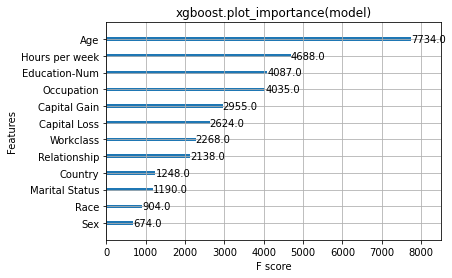

In [22]:
xgboost.plot_importance(model)
pl.title("xgboost.plot_importance(model)")
pl.show()

In [23]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
from shap.explainers import pytree
# explainer = pytree.TreeExplainer(model)
# shap_values = explainer.shap_values(X)


In [24]:
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])

In [25]:
# https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/tree_explainer/Python%20Version%20of%20Tree%20SHAP.html

In [26]:
import sklearn.ensemble
import shap
import numpy as np
import numba
import time
import xgboost

In [27]:
X,y = shap.datasets.boston()
X.shape



Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datase

(506, 13)

In [28]:
model = sklearn.ensemble.RandomForestRegressor(n_estimators=1000, max_depth=4)
model.fit(X, y)



RandomForestRegressor(max_depth=4, n_estimators=1000)

In [29]:
bst = xgboost.train({"learning_rate": 0.01, "max_depth": 4}, xgboost.DMatrix(X, label=y), 1000)

In [30]:
start = time.time()
shap_values = bst.predict(xgboost.DMatrix(X), pred_contribs=True)
print(time.time() - start)

0.0678410530090332


In [31]:
x = np.ones(X.shape[1])
# TreeExplainer(model).shap_values(x)

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
X, y = make_regression(n_features=4, n_informative=2,random_state=0, shuffle=False)
regr = RandomForestRegressor(max_depth=2, random_state=0)
from shap.explainers.pytree import *
regr.fit(X, y)
TreeExplainer(regr)

In [33]:
X, y = make_regression(n_features=4, n_informative=2,random_state=0, shuffle=False)

In [34]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X, y)

RandomForestRegressor(max_depth=2, random_state=0)

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
X, y = make_regression(n_features=4, n_informative=2,random_state=0, shuffle=False)

In [36]:
print(regr.predict([[0, 0, 0, 0]]))

[-8.32987858]


In [37]:
start = time.time()
pytree.TreeExplainer(regr).shap_values(X)
print(time.time() - start)

oryginalna implemenacja shap_values
other model type
using slow python treeshap
0.7483863830566406


In [38]:
from shap.explainers.pytree import TreeExplainer

start = time.time()
TreeExplainer(regr).shap_values(X)
print(time.time() - start)

oryginalna implemenacja shap_values
other model type
using slow python treeshap
0.8089003562927246


In [39]:
t = TreeExplainer(regr)

In [40]:
from pprint import pprint
pprint(vars(t.trees[1]))

{'children_default': array([ 1,  2, -1, -1,  5, -1, -1], dtype=int32),
 'children_left': array([ 1,  2, -1, -1,  5, -1, -1], dtype=int32),
 'children_right': array([ 4,  3, -1, -1,  6, -1, -1], dtype=int32),
 'features': array([ 1,  1, -2, -2,  0, -2, -2], dtype=int32),
 'max_depth': 2,
 'node_sample_weight': array([100.,  67.,  19.,  48.,  33.,  20.,  13.]),
 'thresholds': array([ 0.39371884, -1.36135513, -2.        , -2.        ,  0.68105644,
       -2.        , -2.        ]),
 'values': array([[ -3.86524288],
       [-25.76726583],
       [-57.07966521],
       [-13.3727744 ],
       [ 40.60250067],
       [ 20.3870081 ],
       [ 71.70325847]])}


In [41]:
# t.trees.predict()

In [42]:
str(type(t.trees[1]))

"<class 'shap.explainers.pytree.Tree'>"

In [43]:
pprint((regr.estimators_[1].tree_.weighted_n_node_samples.astype(np.float64)))
# pprint((regr.estimators_[1].tree_.node_sample_weight))


array([100.,  67.,  19.,  48.,  33.,  20.,  13.])


In [44]:
# pprint(dict(regr.estimators_[1].tree_))

In [45]:
for i in range(20):
    pprint(t.trees[i].node_sample_weight)

array([100.,  64.,  37.,  27.,  36.,  26.,  10.])
array([100.,  67.,  19.,  48.,  33.,  20.,  13.])
array([100.,  60.,  18.,  42.,  40.,  27.,  13.])
array([100.,  50.,  26.,  24.,  50.,  38.,  12.])
array([100.,  76.,  39.,  37.,  24.,  13.,  11.])
array([100.,  67.,  35.,  32.,  33.,   6.,  27.])
array([100.,  48.,  28.,  20.,  52.,  38.,  14.])
array([100.,  77.,  30.,  47.,  23.,  18.,   5.])
array([100.,  84.,  38.,  46.,  16.,  11.,   5.])
array([100.,  52.,  15.,  37.,  48.,  35.,  13.])
array([100.,  59.,  34.,  25.,  41.,  31.,  10.])
array([100.,  62.,  15.,  47.,  38.,  23.,  15.])
array([100.,  81.,  50.,  31.,  19.,  12.,   7.])
array([100.,  63.,  27.,  36.,  37.,  23.,  14.])
array([100.,  59.,  38.,  21.,  41.,   6.,  35.])
array([100.,  57.,  34.,  23.,  43.,  32.,  11.])
array([100.,  57.,  17.,  40.,  43.,  29.,  14.])
array([100.,  70.,  28.,  42.,  30.,  18.,  12.])
array([100.,  72.,  38.,  34.,  28.,  25.,   3.])
array([100.,  63.,  41.,  22.,  37.,  21.,  16.])


In [46]:
b_values = t.banz_values(X)
b_values

nasza implementacja banz values
other model type
uzywajac pythonowego banzhafa
dwa wymiary
probka:
[1.76405235 0.40015721 0.97873798 2.2408932 ]
tree:
{'children_default': array([ 1,  2, -1, -1,  5, -1, -1], dtype=int32),
 'children_left': array([ 1,  2, -1, -1,  5, -1, -1], dtype=int32),
 'children_right': array([ 4,  3, -1, -1,  6, -1, -1], dtype=int32),
 'features': array([ 1,  0, -2, -2,  0, -2, -2], dtype=int32),
 'max_depth': 2,
 'node_sample_weight': array([100.,  64.,  37.,  27.,  36.,  26.,  10.]),
 'thresholds': array([ 0.10953759,  0.43508366, -2.        , -2.        ,  0.76641414,
       -2.        , -2.        ]),
 'values': array([[ -2.0710816 ],
       [-19.7675118 ],
       [-34.58580269],
       [  0.53903498],
       [ 29.38923875],
       [ 19.32700042],
       [ 55.55105841]])}
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.421875
ustawiam delta_star od 4 na 0.36
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 

{'children_default': array([ 1,  2, -1, -1,  5, -1, -1], dtype=int32),
 'children_left': array([ 1,  2, -1, -1,  5, -1, -1], dtype=int32),
 'children_right': array([ 4,  3, -1, -1,  6, -1, -1], dtype=int32),
 'features': array([ 1,  1, -2, -2,  0, -2, -2], dtype=int32),
 'max_depth': 2,
 'node_sample_weight': array([100.,  78.,  30.,  48.,  22.,  13.,   9.]),
 'thresholds': array([ 0.92265299, -0.4611522 , -2.        , -2.        ,  1.04410729,
       -2.        , -2.        ]),
 'values': array([[  3.05886377],
       [-13.14987037],
       [-36.94463052],
       [  1.72185472],
       [ 60.5261939 ],
       [ 42.90837985],
       [ 85.97414753]])}
ustawiam delta_star od 1 na 0.78
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.48
B to ZERO dla:
[-4.930091780796418, -4.930091780796418]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.40909090909090906
betas:
[1.         0.6942     0.15       0.3552     0.11       0.0325
 0.031

betas:
[1.     0.3    0.075  0.1125 0.28   0.1342 0.09   1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.    ]
deltas_star:
[0.   0.   0.   0.5  0.4  0.22 0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.  

[0.         0.         0.         0.5        0.36       0.
 0.41666667 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]

[0.         0.         0.         0.37096774 0.38       0.
 0.86842105 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]

ustawiam delta_star od 4 na 0.54
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.8703703703703702
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.4230769230769231
ustawiam delta_star od 4 na 0.22
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.2272727272727273
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-9.552151023469868, -9.552151023469868]
ustawiam delta_star od 4 na 0.31
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.5161290322580645
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.3870967741935484
ustawiam delta_star od 4 na 0.38
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.34210526315789475
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.5874999999999999
ustawiam delta_star od 4 na 0.2
ustawiam delta_star od 5 na 0.0
us

ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.6
ustawiam delta_star od 2 na 0.5
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.58
ustawiam delta_star od 2 na 0.6551724137931035
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.63
ustawiam delta_star od 2 na 0.5238095238095238
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.6486486486486487
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.54
ustawiam delta_star od 2 na 0.611111111111111
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.84
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.55
B to ZERO dla:
[-7.499790496019754, -7.4

ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.6551724137931035
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.42
ustawiam delta_star od 5 na 0.35
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.63
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.47619047619047616
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.6486486486486487
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.38888888888888884
ustawiam delta_star od 4 na 0.46
ustawiam delta_star od 5 na 0.34
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.84
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.55
B to ZERO dla:
[-7.499790496019754, -7.499790496019754]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.5625
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.5178571428

ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-7.046867664100024, -7.046867664100024]
ustawiam delta_star od 4 na 0.57
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.11
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.34782608695652173
ustawiam delta_star od 4 na 0.54
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.13
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.19565217391304346
ustawiam delta_star od 4 na 0.54
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.35185185185185186
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.4342105263157895
ustawiam delta_star od 4 na 0.24
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.4166666666666667
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.4507042253521127
ustawiam delta_star od 4 na 0.29
ustawiam del

ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.3492063492063492
ustawiam delta_star od 4 na 0.37
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.16
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.5116279069767442
ustawiam delta_star od 4 na 0.14
ustawiam delta_star od 5 na 0.5714285714285714
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-9.345359365879085, -9.345359365879085]
ustawiam delta_star od 4 na 0.32
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.13
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.3787878787878788
ustawiam delta_star od 4 na 0.34
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.5588235294117647
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.4

ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.4
B to ZERO dla:
[-9.767379276775156, -9.767379276775156]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.7
ustawiam delta_star od 2 na 0.28
ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-9.917415024643622, -9.917415024643622]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.4
ustawiam delta_star od 1 na 0.72
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.47222222222222227
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.8928571428571428
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.63
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.3492063492063492
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.86
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.51162790

B to ZERO dla:
[-7.394961676885803, -7.394961676885803]
ustawiam delta_star od 4 na 0.36
ustawiam delta_star od 5 na 0.7222222222222223
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.5081967213114754
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.39
ustawiam delta_star od 5 na 0.641025641025641
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.5616438356164384
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.27
ustawiam delta_star od 5 na 0.4074074074074074
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-8.688901025165313, -8.688901025165313]
ustawiam delta_star od 4 na 0.36
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.14
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.5740740740740741
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 n

ustawiam delta_star od 3 na 0.43902439024390244
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.7222222222222223
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.69
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.49
B to ZERO dla:
[-10.4352131611839, -10.4352131611839]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.25806451612903225
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.7551020408163265
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.51
ustawiam delta_star od 5 na 0.38
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.63
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.51
B to ZERO dla:
[-8.889505718324946, -8.889505718324946]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.918918918918919
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.6170212765957447
ustawiam delta_star od 3 

ustawiam delta_star od 1 na 0.46
ustawiam delta_star od 2 na 0.3913043478260869
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.62
ustawiam delta_star od 2 na 0.435483870967742
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.8421052631578947
ustawiam delta_star od 1 na 0.57
ustawiam delta_star od 2 na 0.5964912280701755
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.930232558139535
ustawiam delta_star od 1 na 0.85
ustawiam delta_star od 2 na 0.57
ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-11.529112199102025, -11.529112199102025]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.8
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.81
ustawiam delta_star od 2 na 0.5061728395061728
ustawiam delta_s

ustawiam delta_star od 1 na 0.46
ustawiam delta_star od 2 na 0.41304347826086957
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.8703703703703702
ustawiam delta_star od 1 na 0.78
ustawiam delta_star od 2 na 0.5769230769230769
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.7727272727272728
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.69
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.41
B to ZERO dla:
[-10.830757078888649, -10.830757078888649]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.48387096774193544
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.62
ustawiam delta_star od 2 na 0.6129032258064516
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.6578947368421053
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.8
ustawiam delta_star od 2 na 0.

ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-6.452054572282885, -6.452054572282885]
ustawiam delta_star od 4 na 0.42
ustawiam delta_star od 5 na 0.7142857142857143
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-7.104642974579751, -7.104642974579751]
ustawiam delta_star od 4 na 0.17
ustawiam delta_star od 5 na 0.6470588235294117
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-6.986446802098248, -6.986446802098248]
ustawiam delta_star od 4 na 0.52
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.13
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.7708333333333334
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.52
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.18
ustawiam delt

ustawiam delta_star od 4 na 0.52
ustawiam delta_star od 5 na 0.38
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.77
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.6103896103896104
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.7826086956521738
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.84
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.5476190476190477
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.6875
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-8.784342298978864, -8.784342298978864]
ustawiam delta_star od 4 na 0.48
ustawiam delta_star od 5 na 0.35
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.42372881355932207
ustawiam delta_star od 4 na 0.41
ustawiam delta_star od 5 na 0.7560975609756098
ustawiam delta_star od 6 n

ustawiam delta_star od 1 na 0.64
ustawiam delta_star od 2 na 0.15
ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-7.984086258711137, -7.984086258711137]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.7222222222222223
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.61
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.4918032786885246
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.641025641025641
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.73
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.4383561643835617
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.5925925925925926
ustawiam delta_star od 1 na 0.64
ustawiam delta_star od 2 na 0.15
ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-9.443378575197832, -9.443378575197832]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.54
ustawia

ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.7
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.4000000000000001
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.6333333333333334
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.71
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.36999999999999994
B to ZERO dla:
[-8.301727796653438, -8.301727796653438]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.8275862068965517
ustawiam delta_star od 1 na 0.62
ustawiam delta_star od 2 na 0.6290322580645161
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.868421052631579
ustawiam delta_star od 1 na 0.55
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.37
B to ZERO dla:
[-7.346979060302826, -7.346979060302826]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.7111111111111111
ustawiam de

ustawiam delta_star od 3 na 0.47619047619047616
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.6486486486486487
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.611111111111111
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.46
ustawiam delta_star od 5 na 0.34
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.84
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.55
B to ZERO dla:
[-7.499790496019754, -7.499790496019754]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.5625
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.5178571428571428
ustawiam delta_star od 4 na 0.44
ustawiam delta_star od 5 na 0.25
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.7551020408163265
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.51
ustawiam delta_star od 5 na

ustawiam delta_star od 1 na 0.64
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.49
B to ZERO dla:
[-9.094019264597089, -9.094019264597089]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.7222222222222223
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.61
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.4918032786885246
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.641025641025641
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.73
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.4383561643835617
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.5925925925925926
ustawiam delta_star od 1 na 0.64
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.49
B to ZERO dla:
[-10.481835864056757, -10.481835864056757]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.54
ustaw

ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.53
ustawiam delta_star od 2 na 0.7358490566037735
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.47
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.3
B to ZERO dla:
[-8.72384462359343, -8.72384462359343]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.5094339622641509
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.52
ustawiam delta_star od 2 na 0.7307692307692307
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.55
ustawiam delta_star od 2 na 0.6727272727272726
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.0
ustawiam delta_sta

ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.8461538461538461
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-6.452054572282885, -6.452054572282885]
ustawiam delta_star od 4 na 0.42
ustawiam delta_star od 5 na 0.7142857142857143
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.83
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.49
B to ZERO dla:
[-7.313638279303371, -7.313638279303371]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.6470588235294117
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-6.986446802098248, -6.986446802098248]
ustawiam delta_star od 4 na 0.52
ustawiam delta_star od 5 na 0.39
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.7708333333333334
ustawiam delta_star od 3 na 0.0

ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.67
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.48
B to ZERO dla:
[-10.17257766255975, -10.17257766255975]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.6060606060606061
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.6
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.42
B to ZERO dla:
[-8.483601318840066, -8.483601318840066]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.48
ustawiam delta_star od 4 na 0.5
ustawiam delta_star od 5 na 0.38
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.76
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.4868421052631579
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.67
ustawiam delta_star

ustawiam delta_star od 3 na 0.6
B to ZERO dla:
[-10.808969429045643, -10.808969429045643]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.8275862068965517
ustawiam delta_star od 1 na 0.64
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.49
B to ZERO dla:
[-9.094019264597089, -9.094019264597089]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.7222222222222223
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.61
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.4918032786885246
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.641025641025641
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.73
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.4383561643835617
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.5925925925925926
ustawiam delta_star od 1 na 0.64
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3

ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.4074074074074074
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.64
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.49
B to ZERO dla:
[-10.481835864056757, -10.481835864056757]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.54
ustawiam delta_star od 2 na 0.5740740740740741
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.8478260869565217
ustawiam delta_star od 1 na 0.49
ustawiam delta_star od 2 na 0.7551020408163265
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.53
ustawiam delta_star od 2 na 0.7358490566037735
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.

ustawiam delta_star od 1 na 0.72
ustawiam delta_star od 2 na 0.5277777777777778
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.8928571428571428
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.63
ustawiam delta_star od 2 na 0.6507936507936507
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.86
ustawiam delta_star od 2 na 0.4883720930232558
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.5714285714285714
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.68
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.5
B to ZERO dla:
[-11.550029298618462, -11.550029298618462]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.66
ustawiam delta_star od 2 na 0.6212121212121211
ustawiam delta_

ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.4523809523809524
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.16
ustawiam delta_star od 5 na 0.6875
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-8.784342298978864, -8.784342298978864]
ustawiam delta_star od 4 na 0.48
ustawiam delta_star od 5 na 0.35
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.576271186440678
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.41
ustawiam delta_star od 5 na 0.7560975609756098
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-7.205504597591419, -7.205504597591419]
ustawiam delta_star od 4 na 0.38
ustawiam delta_star od 5 na 0.6052631578947368
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star o

ustawiam delta_star od 3 na 0.28
B to ZERO dla:
[-6.777069694181735, -6.777069694181735]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.8
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.81
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.49382716049382713
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.5789473684210527
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.78
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.5256410256410255
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.7272727272727273
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-7.002551943154586, -7.002551943154586]
ustawiam delta_star od 4 na 0.56
ustawiam delta_star od 5 na 0.42
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-7.046

ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.66
ustawiam delta_star od 2 na 0.6212121212121211
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.4411764705882352
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.49
ustawiam delta_star od 2 na 0.5918367346938775
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.7647058823529412
ustawiam delta_star od 1 na 0.59
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.6101694915254238
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.7317073170731707
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.76
ustawiam delta_star od 2 na 0.41000000000000003
ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-9.513074844675748, -9.513074844675748]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.7083333333333334
ustawiam delta_star od 6 na 0.0
ustawiam delta_star

ustawiam delta_star od 3 na 0.6103896103896104
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.7826086956521738
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.84
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.5476190476190477
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.6875
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.52
ustawiam delta_star od 2 na 0.15
ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-9.397170075729907, -9.397170075729907]
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.0
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.59
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.42372881355932207
ustawiam delta_star od 4 na 0.0
ustawiam delta_star od 5 na 0.7560975609756098
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.62
ustawiam delta_star od 2 na 0.15
ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-7.890535343057346, -7.890535343057346]
ust

B to ZERO dla:
[-8.865683218118397, -8.865683218118397]
ustawiam delta_star od 4 na 0.37
ustawiam delta_star od 5 na 0.22999999999999998
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-7.757985575193117, -7.757985575193117]
ustawiam delta_star od 4 na 0.41
ustawiam delta_star od 5 na 0.14634146341463414
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.5964912280701755
ustawiam delta_star od 3 na 0.0
ustawiam delta_star od 4 na 0.43
ustawiam delta_star od 5 na 0.7441860465116279
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.0
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0.0
B to ZERO dla:
[-8.284957165377865, -8.284957165377865]
ustawiam delta_star od 4 na 0.43
ustawiam delta_star od 5 na 0.29
ustawiam delta_star od 6 na 0.0
ustawiam delta_star od 1 na 0.7
ustawiam delta_star od 2 na 0.0
ustawiam delta_star od 3 na 0

[[1.0118245042597056, 0.0, -0.05668572874907226, -0.1968429266397678, 0.0],
 [-2.9389853735594538, 0.0, -0.0787301788181559, -0.2548199143422799, 0.0],
 [2.74516892932846, 0.0, -0.05668572874907226, -0.1968429266397678, 0.0],
 [-0.599180974141115, 0.0, -0.0787301788181559, -0.2548199143422799, 0.0],
 [-1.72830600931719, 0.0, -0.0787301788181559, -0.17854459067146675, 0.0],
 [3.561746233634827, 0.0, -0.05668572874907226, -0.13618301160709098, 0.0],
 [-2.9389853735594538, 0.0, -0.0787301788181559, -0.2548199143422799, 0.0],
 [1.646401762419117, 0.0, -0.05668572874907226, -0.18343833031390344, 0.0],
 [-2.1216506879634007, 0.0, -0.0787301788181559, -0.2548199143422799, 0.0],
 [1.6051060762895717, 0.0, -0.05668572874907226, -0.18343833031390344, 0.0],
 [-2.06603556128136, 0.0, -0.0787301788181559, -0.2548199143422799, 0.0],
 [-2.0885389569988373, 0.0, -0.0787301788181559, -0.2548199143422799, 0.0],
 [-1.2250612257503626, 0.0, -0.0787301788181559, -0.2548199143422799, 0.0],
 [-2.121147547848

In [47]:
np.set_printoptions(suppress=True)

s_values = t.shap_values(X)
s_values

oryginalna implemenacja shap_values
other model type
using slow python treeshap


array([[ 12.06256442,  20.69726478,  -0.04665993,   0.11276334,
         -3.20691285],
       [ 12.73640279, -20.57745397,  -0.01020686,   0.03698327,
         -3.20691285],
       [ -3.35584635,  21.11805095,  -0.04665993,   0.11276334,
         -3.20691285],
       [  6.80593437,   6.17612424,  -0.01020686,   0.03698327,
         -3.20691285],
       [ 10.68731737,  -6.89031431,  -0.01020686,  -0.08565148,
         -3.20691285],
       [-11.39522609,  21.36698542,  -0.04665993,  -0.24358365,
         -3.20691285],
       [ 12.73640279, -29.88175578,  -0.01020686,   0.03698327,
         -3.20691285],
       [ 13.06286236,  50.07961814,  -0.04665993,   0.18299437,
         -3.20691285],
       [ -8.22592974, -32.23352466,  -0.01020686,   0.03698327,
         -3.20691285],
       [ 11.9599985 ,  48.86209626,  -0.04665993,   0.18299437,
         -3.20691285],
       [ -8.29856582, -30.60504432,  -0.01020686,   0.03698327,
         -3.20691285],
       [ -7.19773733, -18.84112221,  -0.010

In [48]:
regr.predict(X[0, :].reshape(1, -1))
# pokazuje ze wartosci s_values sumuja sie do predykcji dla probek 

array([29.61901976])

In [49]:
def banzhaf_brute(tree, X):
    from itertools import chain, combinations

    def powerset(iterable):
        s = list(iterable)
        return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
    
    U = list(powerset([x for x in tree.features if x != -2]))
    bval = 0.0
    for i in U:
        bval += tree.predict()
    

In [50]:
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [51]:
x = X[0, :]
t.brute_shap(x, 2)

array([-0.04665993])

In [52]:
t.brute_banz(x, 2)

array([-0.04665993])

In [53]:
diffs = [t.brute_shap(X[i, :], 2) - t.brute_banz(X[i, :], 2) for i in range(100)]
print([list(_a) for _a in diffs if _a > 0.000001])  # roznice są na poziomie eps
print(list(diffs[0]))  # przykladowa wartosc

[]
[4.996003610813204e-16]


In [54]:
t.banz_values

<bound method TreeExplainer.banz_values of <shap.explainers.pytree.TreeExplainer object at 0x7f86865ddb40>>

In [55]:
from shap.explainers import Tree as TreeCext
t_cext = TreeCext(regr)
t_cext.shap_values(X)

using treeshap and cext
here37
using dense_Tree_pred


array([[ 12.06256442,  20.69726478,  -0.04665993,   0.11276334],
       [ 12.73640279, -20.57745397,  -0.01020686,   0.03698327],
       [ -3.35584635,  21.11805095,  -0.04665993,   0.11276334],
       [  6.80593437,   6.17612424,  -0.01020686,   0.03698327],
       [ 10.68731737,  -6.89031431,  -0.01020686,  -0.08565148],
       [-11.39522609,  21.36698542,  -0.04665993,  -0.24358365],
       [ 12.73640279, -29.88175578,  -0.01020686,   0.03698327],
       [ 13.06286236,  50.07961814,  -0.04665993,   0.18299437],
       [ -8.22592974, -32.23352466,  -0.01020686,   0.03698327],
       [ 11.9599985 ,  48.86209626,  -0.04665993,   0.18299437],
       [ -8.29856582, -30.60504432,  -0.01020686,   0.03698327],
       [ -7.19773733, -18.84112221,  -0.01020686,   0.03698327],
       [ -9.35344065, -14.34162332,  -0.01020686,   0.03698327],
       [ -7.80116218, -24.57496898,  -0.01020686,   0.03698327],
       [  0.24250186,  15.90655976,  -0.01020686,   0.0702702 ],
       [ -8.02110892, -18